# PPE: A GraphEM-based Reconstruction

**Expected time to run through: ~0.5 hrs**

In this section, we illustrate the basic workflow of the Graphical Expectation-Maximization algorithm (GraphEM, [Guillot et al., 2015](https://doi.org/10.1214/14-AOAS794)) with `cfr`, conducting a pseudoproxy experiment (PPE) with the pseudoPAGES2k dataset.
Due to the intensive computational requirement of the GraphEM method, our goal is to reconstruct the air surface temperature field only over the tropical Pacific region using coral records.

Required data to complete this tutorial:

- iCESM simulated air surface temperature: [tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- iCESM simulated precipitation rate: [pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- pseudoPAGES2k: [ppwn_SNRinf_rta.nc](https://github.com/fzhu2e/paper-pseudoPAGES2k/raw/main/data/ppwn_SNRinf_rta.nc)

Note: `pip install "cfr[graphem]"` to enable the GraphEM method if not done before.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)
import numpy as np

## GraphEM steps
### Create a reconstruction job object `cfr.ReconJob` and load the pseudoPAGES2k database

A `cfr.ReconJob` object takes care of the workflow of a reconstruction task.
It provides a series of attributes and methods to help the users go through each step of the reconstruction task, such as loading the proxy database, loading the model prior, calibrating and running the proxy system models, performing the data assimilation solver, etc.

(800.0, 2000.0)

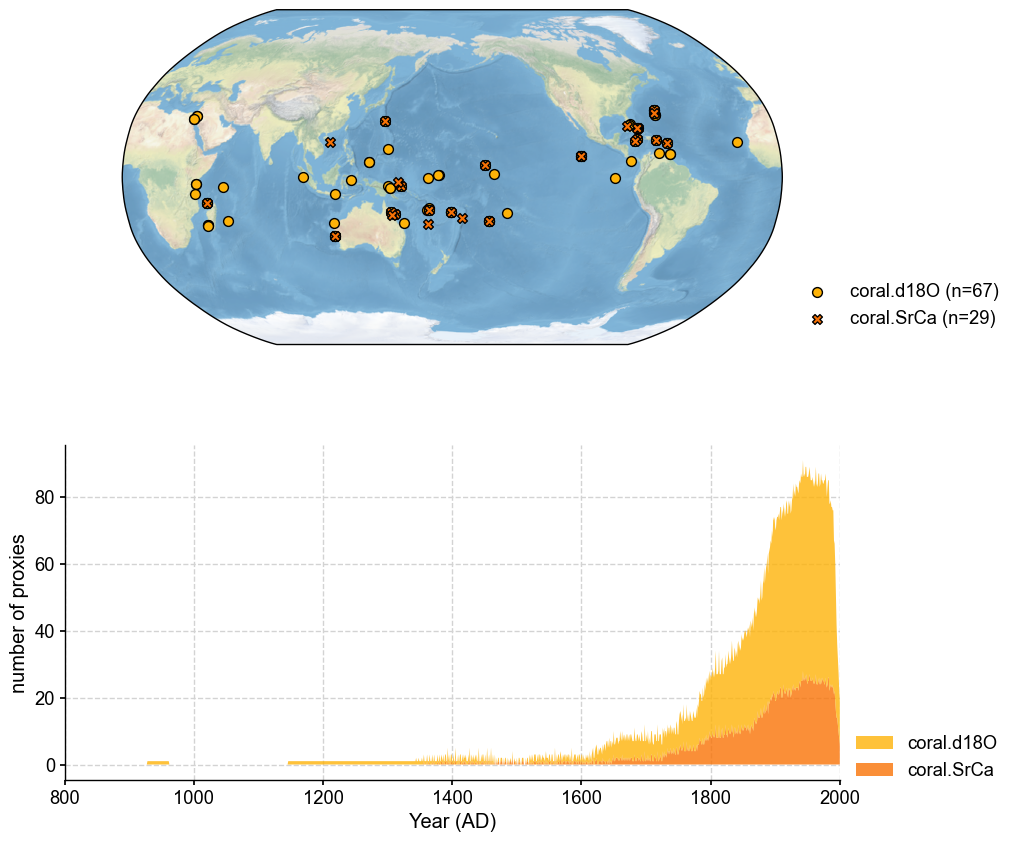

In [2]:
# create a reconstruction job object using the `cfr.ReconJob` class
job = cfr.ReconJob()

# load the pseudoPAGES2k database from a netCDF file

# load from a local copy
# job.proxydb = cfr.ProxyDatabase().load_nc('./data/ppwn_SNRinf_rta.nc')

# load from the cloud
job.load_proxydb('pseudoPAGES2k/ppwn_SNRinf_rta')

# filter the database
job.filter_proxydb(by='ptype', keys='coral')

# plot to have a check of the database
fig, ax = job.proxydb.plot(plot_count=True)
ax['count'].set_xlim(800, 2000)

### Annualize each proxy record

In [3]:
job.annualize_proxydb(months=list(range(1, 13)), verbose=True)

>>> job.configs["annualize_proxydb_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> job.configs["annualize_proxydb_ptypes"] = {'coral.d18O', 'coral.SrCa'}


Annualizing ProxyDatabase: 100%|██████████| 96/96 [00:04<00:00, 22.53it/s]

>>> 96 records remaining
>>> job.proxydb updated


### Center each proxy record

In [4]:
job.center_proxydb(ref_period=[1951, 1980], verbose=True)

>>> job.configs["proxydb_center_ref_period"] = [1951, 1980]


Centering each of the ProxyRecord:   0%|          | 0/96 [00:00<?, ?it/s]/glade/work/fengzhu/conda-envs/cfr-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/work/fengzhu/conda-envs/cfr-env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Centering each of the ProxyRecord: 100%|██████████| 96/96 [00:00<00:00, 2874.16it/s]

>>> job.proxydb updated


GraphEM requires that the proxy availability to be as uniform as possible, we thus filter the proxy database further to achieve that.

(1801.0, 2000.0)

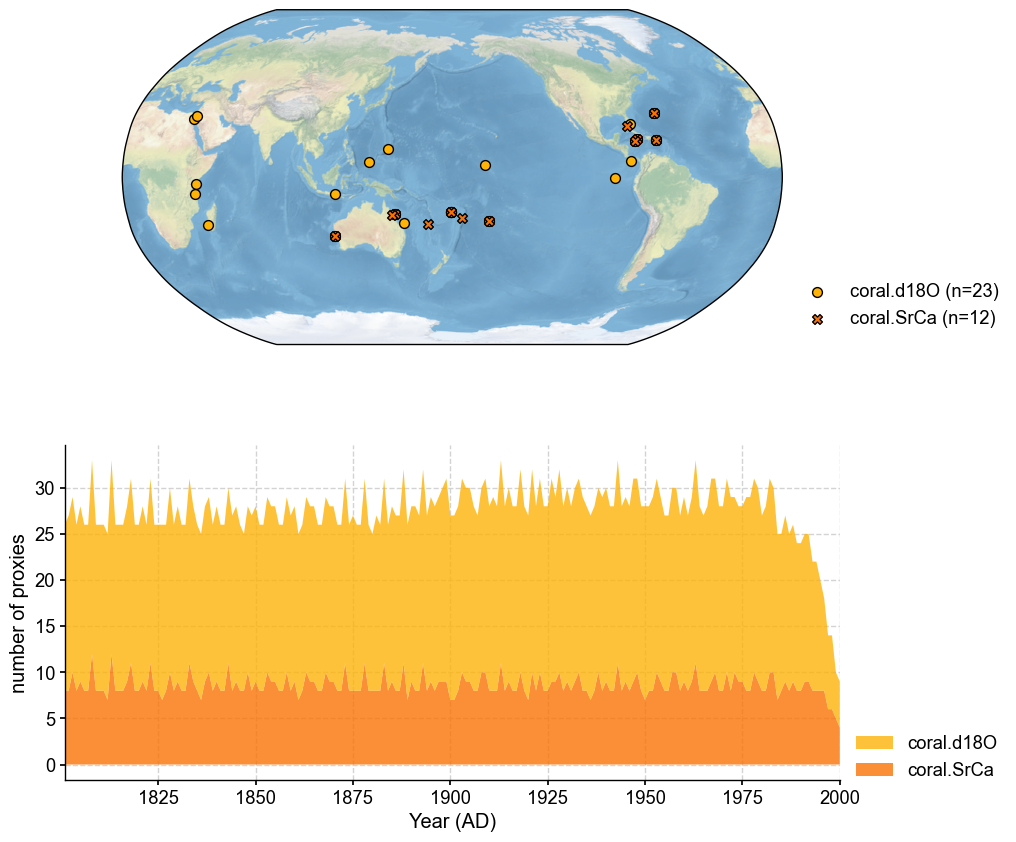

In [5]:
pdb = job.proxydb.copy()

pobj_list = []
recon_period = [1801, 2000]
for pobj in pdb:
    if np.min(pobj.time) <= recon_period[0]:
        pobj_list.append(pobj)
    
new_pdb = cfr.ProxyDatabase()
new_pdb += pobj_list

job.proxydb = new_pdb
fig, ax = job.proxydb.plot(plot_count=True)
ax['count'].set_xlim(*recon_period)

### Load the instrumental observations

As a perfect model prior pseudoproxy experiment (PPE), we use the iCESM simulated fields as instrumental observations.

In [6]:
job.load_clim(
    tag='obs',
    path_dict={
        # 'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',  # load from a local copy
        'tas': 'iCESM_past1000historical/tas',  # load from the cloud
    },
    anom_period=(1951, 1980),
    load=True,  # load the data into memeory to accelerate the later access; requires large memeory
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


### Annualize the observation fields

This step will determine the temporal resolution of the reconstructed fields.

In [7]:
job.annualize_clim(tag='obs', verbose=True, months=list(range(1, 13)))

>>> job.configs["obs_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.obs updated


### Regrid the observation fields

This step will determine the spatial resolution of the reconstructed fields.

In [8]:
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)

>>> job.configs["obs_regrid_nlat"] = 42
>>> job.configs["obs_regrid_nlon"] = 63
>>> Processing tas ...


### Crop the observations fields to make the problem size smaller

In [9]:
job.crop_clim(tag='obs', lat_min=-25, lat_max=25, lon_min=120, lon_max=280, verbose=True)

>>> job.configs["prior_lat_min"] = -25
>>> job.configs["prior_lat_max"] = 25
>>> job.configs["prior_lon_min"] = 120
>>> job.configs["prior_lon_max"] = 280
>>> Processing tas ...


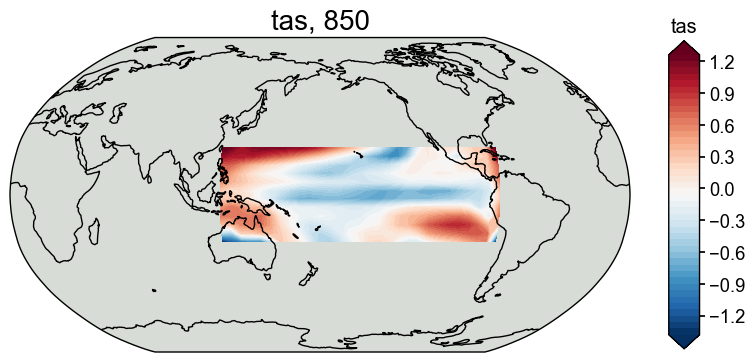

In [10]:
# check the cropped domain
fig, ax = job.obs['tas'][0].plot()

### (Optional) Save the job object for later reload

Save the job object before running the DA procedure for a quick reload next time if needed.

In [11]:
job.save('./cases/pp2k-ppe-graphem', verbose=True)

>>> job.configs["save_dirpath"] = ./cases/pp2k-ppe-graphem
>>> obs_tas saved to: ./cases/pp2k-ppe-graphem/obs_tas.nc
>>> job saved to: ./cases/pp2k-ppe-graphem/job.pkl


Now let's reload the job object from the saved directory.

In [12]:
job = cfr.ReconJob()
job.load('./cases/pp2k-ppe-graphem/', verbose=True)

>>> job is loaded
>>> job.obs["tas"].da is loaded


### Prepare the GraphEM solver

In [13]:
job.prep_graphem(
    recon_period=(1801, 2000),  # period to reconstruct
    calib_period=(1901, 2000),  # period for calibration
    verbose=True,
)

>>> job.configs["recon_period"] = (1801, 2000)
>>> job.configs["recon_timescale"] = 1
>>> job.configs["calib_period"] = (1901, 2000)
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created
>>> job.graphem_params["field_obs"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created


### Run the GraphEM solver

We will take the Empirical Graphs (graphical lasso, `glasso`) approach.

In [14]:
job.run_graphem(
    save_dirpath='./recons/pp2k-ppe-graphem',
    graph_method='glasso',
    verbose=True,
)

>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 1}
>>> job.configs["save_dirpath"] = ./recons/pp2k-ppe-graphem
>>> job.configs["save_filename"] = job_r01_recon.nc
Applying the graphical lasso
Infilling missing values over the calibration period using RegEM iridge


EM | dXmis: 0.0005; rdXmis: 0.0047:  14%|█▍        | 29/200 [02:07<12:30,  4.39s/it]


GraphEM.EM(): Tolerance achieved.
Solving graphical LASSO using greedy search


graph_greedy_search | FF:  3.625; FP:  3.903; PP:  3.529: 100%|██████████| 500/500 [01:46<00:00,  4.69it/s]


Running GraphEM:



EM | dXmis: 0.0019; rdXmis: 0.0050:  10%|█         | 20/200 [00:18<02:44,  1.09it/s]

GraphEM.EM(): Tolerance achieved.
job.graphem_solver created and saved to: None
>>> job.recon_fields created
>>> Reconstructed fields saved to: ./recons/pp2k-ppe-graphem/job_r01_recon.nc


## Validation steps

### Create the reconstruction result object `cfr.ReconRes`.

A `cfr.ReconRes` object takes care of the workflow of postprocessing and analyzing the reconstruction results.
It provides handy methods to help the users load, validate, and visualize the reconstruction results.

In [15]:
res = cfr.ReconRes('./recons/pp2k-ppe-graphem', verbose=True)

>>> res.paths:
['./recons/pp2k-ppe-graphem/job_r01_recon.nc']


### Load the reconstructed variables

Here we validate the `tas` field and the NINO3.4 index as an example.

In [16]:
res.load(['tas', 'nino3.4'], verbose=True)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created


### Validate the reconstructed NINO3.4

We calculate the annualized NINO3.4 from the "instrumental observations" as a reference for validation.

In [18]:
da = job.obs['tas'].da
da = cfr.utils.geo_mean(da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = da.time.values
ref_value = da.values
ref_name = 'target'

We use a chain calling of several methods, including the validation step `.validate()` and the plotting step `.plot_qs()`.

(-2.0, 3.0)

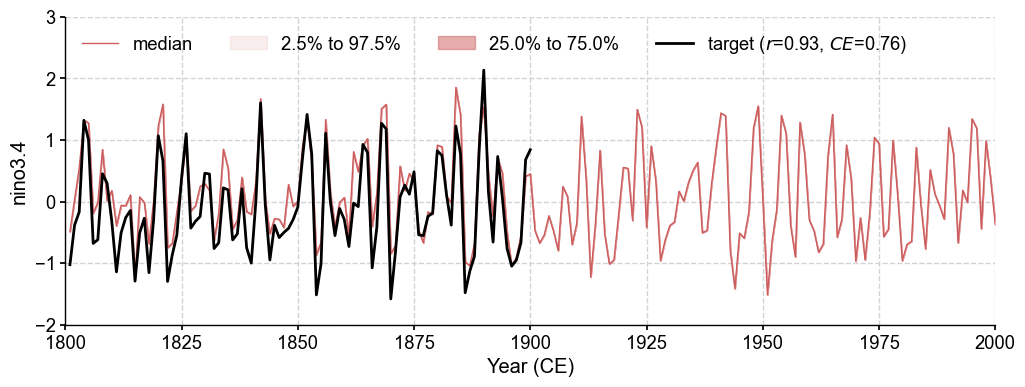

In [19]:
fig, ax = res.recons['nino3.4'].compare(ref_time, ref_value, ref_name, timespan=(1801, 1900)).plot_qs()
ax.set_xlim(1800, 2000)
ax.set_ylim(-2, 3)

### Validate the reconstructed fields

In [20]:
# Preparations to add markers representing the sites on the map

lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pid, pobj in job.proxydb.records.items():
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 50

Calculating and visualizing the coefficient of determination ($R^2$) between the reconstructed and target fields, we see overall high skills.

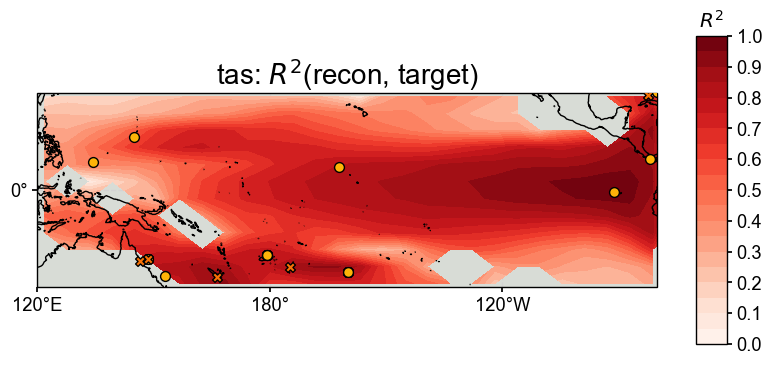

In [21]:
stat = 'R2'
valid_fd = res.recons['tas'].compare(
    job.obs['tas'], stat=stat,
    timespan=(1801, 1900),
)
fig, ax = valid_fd.plot(
    title=fr'tas: $R^2$(recon, target)',
    projection='PlateCarree',
    latlon_range=(-25, 25, 120, 280),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
)

Note that there are regions where color is not filled.
The values there are NaNs, and it is caused by the constant values in the reconstruction.

In [24]:
res.recons['tas']['1801':'1900'].da[:, 0, 0]

<xarray.DataArray 'tas' (time: 100)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * time     (time) int64 1801 1802 1803 1804 1805 ... 1896 1897 1898 1899 1900
    lat      float64 -24.15
    lon      float64 121.9

In contrast to $R^2$, the coefficient of efficiency ($CE$) measures not only the linear correlation between two timeseries, but also the bias in amplitude.
Calculating and visualizing $CE$ between the reconstructed and the target fields, we see overall similar spatial patterns of the high and low skill regions.

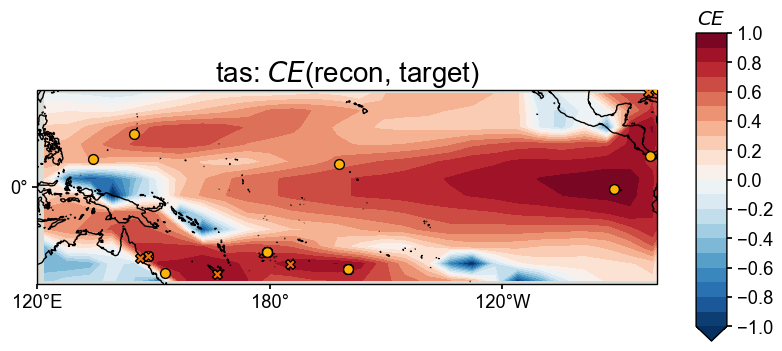

In [25]:
stat = 'CE'
valid_fd = res.recons['tas'].compare(
    job.obs['tas'], stat=stat,
    timespan=(1801, 1900),
)
fig, ax = valid_fd.plot(
    title=fr'tas: $CE$(recon, target)',
    projection='PlateCarree',
    latlon_range=(-25, 25, 120, 280),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
)